In [1]:
# Load Libraries
import warnings
warnings.filterwarnings('ignore')


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout



#from keras.preprocessing.image import ImageDataGenerator

import os

Using TensorFlow backend.


In [2]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Import matplotlib to load, view, and test unseen plume & no-plume images from the larger plume and dummy directories
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

### Load two dataframes. First is perm_list from 2019 Permian basin plumes. This csv has facility type and industry sector plus image file names linled by the candidate_id.  The second is plum_att from the Plume Attributes 2021-2022 list that also has landfill and agriculture plumes.

In [3]:
perm_list = pd.read_csv('permian_plume_list_2019_facility_sector_oldpng_and_ctr_tif_names_pers_conf_with_newPNG_names.csv')
perm_list.drop(labels = ['Unnamed: 0', 'Unnamed: 0.1','Unnamed: 0.1.1'], axis = 1, inplace = True)
perm_list.head()

,source_id,plume_lat,plume_lon,candidate_id,date,time,qplume,sigma_qplume,active_flair_detected,inactive_flair_detected,file_name,type,ipcc_sector,new_rgb_file_name,new_ctr_file_name,source_persistence,confidence_in_persistence,new_png_file_name
0,P00001,32.212063,-103.697076,ang20190922t192642-2,2019-09-22,19:26:42,2579.528100,902.732655,False,False,ang20190922t192642-2_r4578_c217-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t192642-2_r4578_c217_rgb.tif,ang20190922t192642-2_r4578_c217_ctr.tif,0.833333,0.968324,ang20190922t192642-2_r4578_c217_.png
1,P00002,32.200072,-103.673301,ang20190922t192642-4,2019-09-22,19:26:42,420.725207,147.155782,False,False,ang20190922t192642-4_r4928_c373-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t192642-4_r4928_c373_rgb.tif,ang20190922t192642-4_r4928_c373_ctr.tif,0.333333,0.968324,ang20190922t192642-4_r4928_c373_.png
2,P00003,32.116008,-103.626345,ang20190922t192642-5,2019-09-22,19:26:42,1051.909600,339.267587,False,False,ang20190922t192642-5_r6423_c113-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t192642-5_r6423_c113_rgb.tif,ang20190922t192642-5_r6423_c113_ctr.tif,0.583333,0.968324,ang20190922t192642-5_r6423_c113_.png
3,P00004,32.322594,-103.816072,ang20190922t194340-1,2019-09-22,19:43:40,1736.644250,1035.427670,False,False,ang20190922t194340-1_r1953_c438-plume.png,pipeline,1B2 Oil & Natural Gas,ang20190922t194340-1_r1953_c438_rgb.tif,ang20190922t194340-1_r1953_c438_ctr.tif,0.090909,0.957765,ang20190922t194340-1_r1953_c438_.png
4,P00005,32.284083,-103.793989,ang20190922t194340-2,2019-09-22,19:43:40,870.605019,435.968147,False,False,ang20190922t194340-2_r2642_c324-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t194340-2_r2642_c324_rgb.tif,ang20190922t194340-2_r2642_c324_ctr.tif,0.200000,0.943686,ang20190922t194340-2_r2642_c324_.png


In [4]:
perm_list.shape

(3067, 18)

In [5]:
perm_list['Sigma_percent'] = perm_list['sigma_qplume'] / perm_list['qplume']

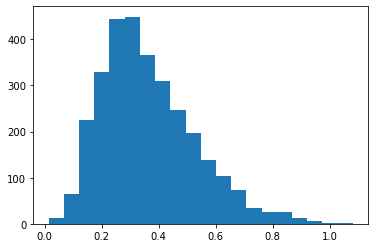

In [6]:
plt.hist(perm_list['Sigma_percent'], bins = 20)
plt.show()

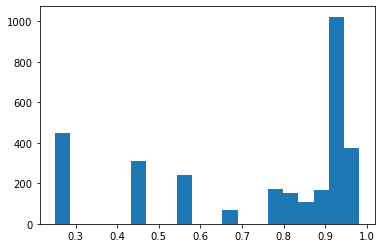

In [7]:
# Reduce by low confidence values
plt.hist(perm_list['confidence_in_persistence'], bins = 20)
plt.show()

#### Reduce the Permian, and later the Plume Atrributes list based on ratio of Q-Sigma to Q-Plume

In [8]:
#reduced_perm = perm_list[perm_list['confidence_in_persistence'] >= 0.5]
#reduced_perm = perm_list[perm_list['qplume'] <= 10000]
reduced_perm = perm_list[perm_list['Sigma_percent'] <= 0.50].reset_index()
reduced_perm.shape

(2466, 20)

In [9]:
plume_att = pd.read_csv('plume_attributes_2020_2021_w_RGB_CTR_PNG_files.csv')
plume_att.drop(labels = ['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)
plume_att.head()

,source_id,candidate_id,plume_lat,plume_lon,date,qplume,sigma_qplume,file_names,source_type,ipcc,rgb_file_names,ctr_file_names,new_png_file_names
0,C00203,ang20200708t192518-3,34.319899,-118.51149,2020-07-08,339.311781,204.404889,"['ang20200708t192518-3_r1823_c108_rgb.tif', 'a...",landfill,6A Solid Waste Disposal On Land,ang20200708t192518-3_r1823_c108_rgb.tif,ang20200708t192518-3_r1823_c108_ctr.tif,ang20200708t192518-3_r1823_c108.png
1,C00015,ang20200708t212342-A,35.586067,-119.69757,2020-07-08,86.983757,51.766121,"['ang20200708t212342-A_r3676_c235_ctr.tif', 'a...",compressor,1B2 Oil & Natural Gas,ang20200708t212342-A_r3676_c235_rgb.tif,ang20200708t212342-A_r3676_c235_ctr.tif,ang20200708t212342-A_r3676_c235.png
2,C00060,ang20200708t203038-D,35.284754,-119.42779,2020-07-08,443.621795,119.196677,"['ang20200708t203038-D_r4790_c390_ctr.tif', 'a...",pipeline,1B2 Oil & Natural Gas,ang20200708t203038-D_r4790_c390_rgb.tif,ang20200708t203038-D_r4790_c390_ctr.tif,ang20200708t203038-D_r4790_c390.png
3,C00059,ang20200708t203038-C,35.286447,-119.47250,2020-07-08,336.616424,71.527967,"['ang20200708t203038-C_r3457_c132_ctr.tif', 'a...",pipeline,1B2 Oil & Natural Gas,ang20200708t203038-C_r3457_c132_rgb.tif,ang20200708t203038-C_r3457_c132_ctr.tif,ang20200708t203038-C_r3457_c132.png
4,C00058,ang20200708t203038-A,35.296764,-119.53737,2020-07-08,75.967913,37.520577,"['ang20200708t203038-A_r1455_c42_ctr.tif', 'an...",pipeline,1B2 Oil & Natural Gas,ang20200708t203038-A_r1455_c42_rgb.tif,ang20200708t203038-A_r1455_c42_ctr.tif,ang20200708t203038-A_r1455_c42.png


In [10]:
plume_att.tail()

,source_id,candidate_id,plume_lat,plume_lon,date,qplume,sigma_qplume,file_names,source_type,ipcc,rgb_file_names,ctr_file_names,new_png_file_names
2519,E0529,GAO20210810t174326p0000-B,32.043686,-101.93975,2021-08-10,140.529133,16.254703,['GAO20210810t174326p0000-B_r10183_c1341_ctr.t...,tank,1B2 Oil & Natural Gas,GAO20210810t174326p0000-B_r10183_c1341_rgb.tif,GAO20210810t174326p0000-B_r10183_c1341_ctr.tif,GAO20210810t174326p0000-B_r10183_c1341.png
2520,E0528,GAO20210810t174326p0000-A,32.089413,-101.93761,2021-08-10,589.289818,174.091222,['GAO20210810t174326p0000-A_r9055_c1354_ctr.ti...,well,1B2 Oil & Natural Gas,GAO20210810t174326p0000-A_r9055_c1354_rgb.tif,GAO20210810t174326p0000-A_r9055_c1354_ctr.tif,GAO20210810t174326p0000-A_r9055_c1354.png
2521,E0076,GAO20210810t172757p0000-G,31.627651,-101.88161,2021-08-10,347.806144,71.069712,['GAO20210810t172757p0000-G_r20051_c2312_ctr.t...,pipeline,1B2 Oil & Natural Gas,GAO20210810t172757p0000-G_r20051_c2312_rgb.tif,GAO20210810t172757p0000-G_r20051_c2312_ctr.tif,GAO20210810t172757p0000-G_r20051_c2312.png
2522,E0271,GAO20210810t184214p0000-A,31.799272,-102.09042,2021-08-10,182.142985,49.808248,['GAO20210810t184214p0000-A_r978_c537_ctr.tif'...,compressor,1B2 Oil & Natural Gas,GAO20210810t184214p0000-A_r978_c537_rgb.tif,GAO20210810t184214p0000-A_r978_c537_ctr.tif,GAO20210810t184214p0000-A_r978_c537.png
2523,E0026,GAO20210810t160102p0000-A,32.373140,-101.84668,2021-08-10,1908.058814,607.843804,['GAO20210810t160102p0000-A_r2102_c269_ctr.tif...,compressor,1B2 Oil & Natural Gas,GAO20210810t160102p0000-A_r2102_c269_rgb.tif,GAO20210810t160102p0000-A_r2102_c269_ctr.tif,GAO20210810t160102p0000-A_r2102_c269.png


In [11]:
plume_att['Sigma_percent'] = plume_att['sigma_qplume'] / plume_att['qplume']

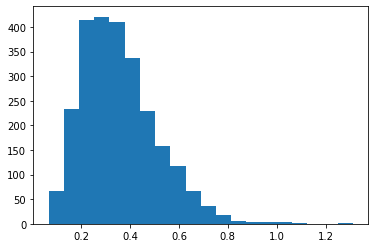

In [12]:
plt.hist(plume_att['Sigma_percent'], bins = 20)
plt.show()

In [13]:
#reduced_plume = plume_att[plume_att['qplume'] < 10000]
reduced_plume = plume_att[plume_att['Sigma_percent'] <= 0.50].reset_index()
reduced_plume.shape

(2106, 15)

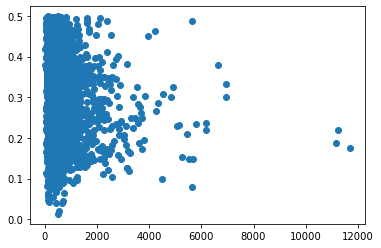

In [14]:
plt.scatter(reduced_perm['qplume'],  reduced_perm['Sigma_percent'])
plt.show()

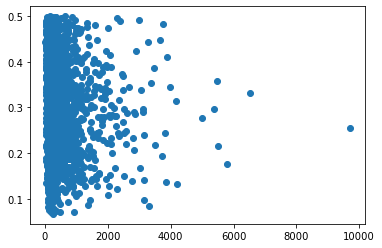

In [15]:
plt.scatter(reduced_plume['qplume'],  reduced_plume['Sigma_percent'])
plt.show()

In [16]:
reduced_perm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      2466 non-null   int64  
 1   source_id                  2466 non-null   object 
 2   plume_lat                  2466 non-null   float64
 3   plume_lon                  2466 non-null   float64
 4   candidate_id               2466 non-null   object 
 5   date                       2466 non-null   object 
 6   time                       2466 non-null   object 
 7   qplume                     2466 non-null   float64
 8   sigma_qplume               2466 non-null   float64
 9   active_flair_detected      2466 non-null   bool   
 10  inactive_flair_detected    2466 non-null   bool   
 11  file_name                  2466 non-null   object 
 12  type                       2426 non-null   object 
 13  ipcc_sector                2466 non-null   objec

In [17]:
reduced_plume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               2106 non-null   int64  
 1   source_id           2106 non-null   object 
 2   candidate_id        2106 non-null   object 
 3   plume_lat           2106 non-null   float64
 4   plume_lon           2106 non-null   float64
 5   date                2106 non-null   object 
 6   qplume              2106 non-null   float64
 7   sigma_qplume        2106 non-null   float64
 8   file_names          2106 non-null   object 
 9   source_type         2096 non-null   object 
 10  ipcc                2096 non-null   object 
 11  rgb_file_names      2106 non-null   object 
 12  ctr_file_names      2106 non-null   object 
 13  new_png_file_names  2106 non-null   object 
 14  Sigma_percent       2106 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 246.9+

### Establish bins on Plume Rates of 500kg/hr increments to stratify the  train - test split (Set a max of 6 bins)

In [18]:
reduced_perm['bin'] = reduced_perm['qplume']/500
reduced_perm['bin'] = reduced_perm['bin'].astype(int)

In [19]:
reduced_perm['bin'].max(), reduced_perm['bin'].min()

(23, 0)

In [20]:
reduced_plume['bin'] = reduced_plume['qplume']/500
reduced_plume['bin'] = reduced_plume['bin'].astype(int)

In [21]:
reduced_plume['bin'].max(), reduced_plume['bin'].min()

(19, 0)

In [22]:
max(reduced_perm['qplume'])

11687.9421

In [23]:
for val in range(6,20):
    reduced_plume['bin'].replace(val, 5, inplace = True)
    print(val)


6
7
8
9
10
11
12
13
14
15
16
17
18
19


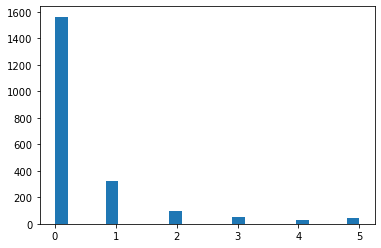

In [24]:
plt.hist( reduced_plume['bin'], bins = 24)
plt.show()

In [25]:
reduced_perm['bin'] = reduced_perm['qplume']/500
reduced_perm['bin'] = reduced_perm['bin'].astype(int)

In [26]:
reduced_perm['bin'].max(), reduced_perm['bin'].min()

(23, 0)

In [27]:
for val in range(6,24):
    reduced_perm['bin'].replace(val, 5, inplace = True)
    print(val)

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


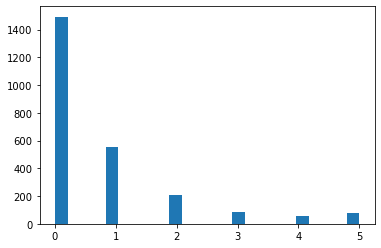

In [28]:
plt.hist( reduced_perm['bin'], bins = 24)
plt.show()

#### Put bins into a single numpy array to cover both q-plume dataframes.  This will be in the split later

In [29]:
q_bin = np.zeros(len(reduced_perm['bin']) + len(reduced_plume['bin']))
q_bin[0:len(reduced_perm['bin'])] = reduced_perm['bin']
q_bin[len(reduced_perm['bin']):] = reduced_plume['bin']
q_bin.shape

(4572,)

#### Add a parallel target numpy array with actual plume rates from both dataframes

In [30]:
Y = np.zeros(len(q_bin))
Y[0:len(reduced_perm['bin'])] = reduced_perm['qplume']
Y[len(reduced_perm['bin']):] = reduced_plume['qplume']
Y.shape

(4572,)

### Prescale the q_plume rates so that the lower end has a larger percentage of the 0 to 1 range with the highest plume rates around 10,000.  These will then be scaled on min-max 0 to 1.  On rescaling from the prediction requires inverse transform of the mon-max scaler and then reverse prescaling using numpy power function.

In [31]:
Y3_4 = np.power(Y, (3/4))

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [33]:
y = scaler.fit_transform(Y3_4.reshape(-1,1))

In [34]:
from pickle import dump

In [35]:
# Save the scaler
dump(scaler, open('scaler_rev14.pkl', 'wb'))

In [36]:
# Initiate an empty np array, set image size to 160 x 160 to be a multiple of 8. 
# Some images are this size, others will be resized as required
NumImages = len(q_bin)

image_set = np.zeros((NumImages,160,160,4))

In [37]:
reduced_perm['new_png_file_name'].tail()

2461    GAO20191103t183806p0000-D_r5775_c1685_.png
2462     GAO20191103t185130p0000-A_r6709_c487_.png
2463    GAO20191103t190631p0000-A_r4957_c3053_.png
2464    GAO20191103t190631p0000-B_r5030_c3001_.png
2465     GAO20191103t190631p0000-C_r7026_c574_.png
Name: new_png_file_name, dtype: object

In [38]:
reduced_plume['new_png_file_names'].tail()

2101    GAO20210810t174326p0000-B_r10183_c1341.png
2102     GAO20210810t174326p0000-A_r9055_c1354.png
2103    GAO20210810t172757p0000-G_r20051_c2312.png
2104       GAO20210810t184214p0000-A_r978_c537.png
2105      GAO20210810t160102p0000-A_r2102_c269.png
Name: new_png_file_names, dtype: object

In [39]:
from PIL import Image

In [40]:
# Read and resize function originally for training on unprocessed images(including the background)
def Resize(Path, Size):
    img1 = Image.open(Path)
    img1 = img1.resize(Size)
    img1 = np.asarray(img1)/255
    return img1

In [1]:
# Read, Resize, and pre-process the image to focus on the plume and remove as much of the background as possible
# This was based on using the PNG images in the competition
# Other models were based on the ctr.tif images which only included the plume itself

def Resize_Filter_for_RedandPurple_Plume(Path, Size, color):
    a, b = 0, 3
    img1 = Image.open(Path)
    #img1 = img1.resize(Size)
    img1 = np.asarray(img1)/255
    #Red Plume Processing
    if color == 'red':
        img1[:,:,b] = np.multiply(img1[:,:,b] ,  img1[:,:,a] >= 0.95  )
        return img1
    #Purple Plume Processing
    else:
        img2 = Image.open(Path)
        #img2 = img2.resize(Size)
        img2 = np.asarray(img2)/255
        img3 = Image.open(Path)
        #img3 = img3.resize( Size)
        img3 = np.asarray(img3)/255       
       
        #Capture Red
        img3[:,:,b] = np.multiply(img3[:,:,b] ,  img3[:,:,a] >= 0.95  )
        #Capture green / yellow 
        img1[:,:,b] = np.multiply(img1[:,:,b] ,  img1[:,:,a+1] >= 0.8  )
        #print(img1.shape)
        img1[:,:,b] = np.multiply( img1[:,:, b] ,  img1[:,:,a+1] <= 0.9 )
        #print(img1.shape)
        #Capture Purple
        img2[:,:,b] = img2[:,:, b] * ( img2[:,:,a+2] >= 0.75 )
        # Merge
        img2[:,:,b] = img2[:,:,b] * (img2[:,:,b] > img1[:,:,b] ) + img1[:,:,b] * (img1[:,:,b] > img2[:,:,b]) + img2[:,:,b] * (img2[:,:,b] == img1[:,:,b])
    
        img3[:,:,b] = img2[:,:,b] * (img2[:,:,b] > img3[:,:,b] ) + img3[:,:,b] * (img3[:,:,b] > img2[:,:,b]) + img2[:,:,b] * (img2[:,:,b] == img3[:,:,b])
  
        return img3

### Below is the ctr image for sample 0. Below that is the PNG images and processed to remove background. The same sample is shown as the first image in the montage with good but not perfect plume extraction.

(160, 160, 4)


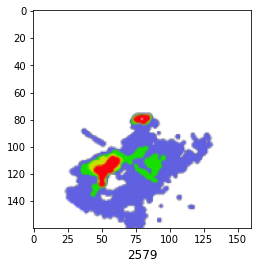

In [30]:
path = 'Purple_Plumes/permian_2019/permian_2019_rgb_ctr/' + reduced_plume['new_ctr_file_name'].loc[0]
img1 = Image.open(path)
img1 = img1.resize((160,160))
img1 = np.asarray(img1)/255
print(img1.shape)
plt.imshow(img1)
plt.xlabel(str(int(reduced_plume['qplume'].loc[0])), fontsize = 12 )
plt.show()

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 Sample of Loaded and Filtered Image set for Plume, shape is  (4572, 160, 160, 4)


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

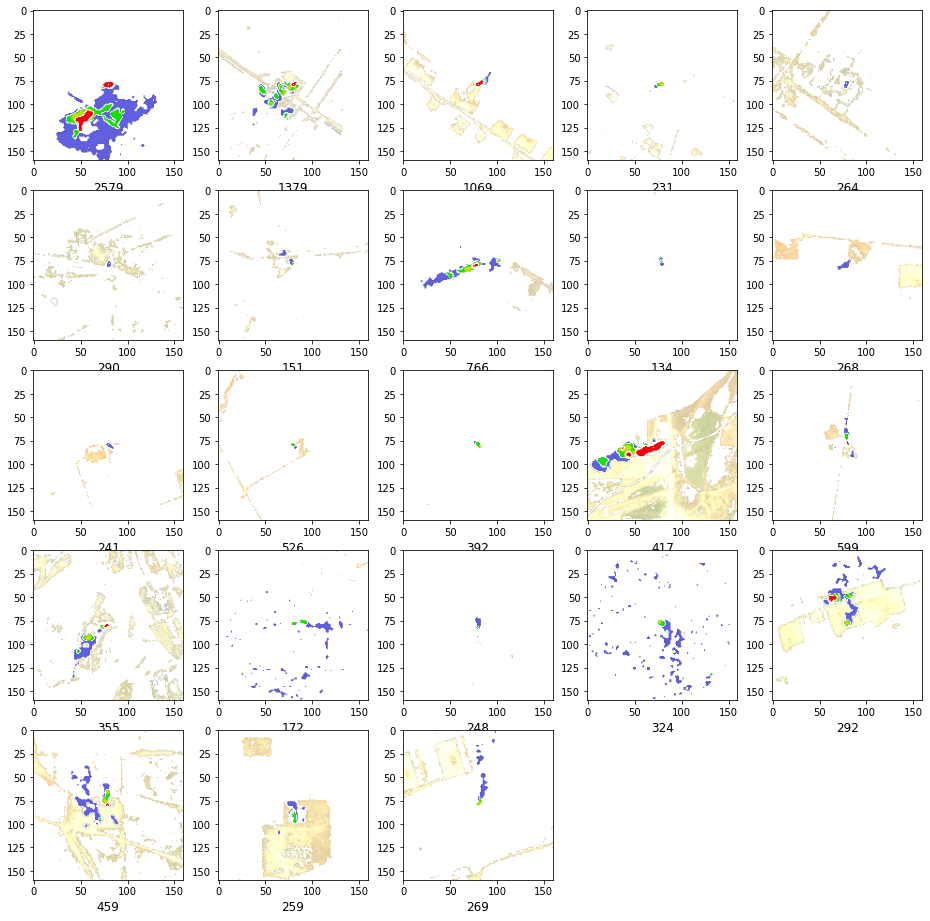

In [49]:
# Read image files into the np array and preview images 0, 200, 400,... to 4400
i = 0
L1 = len(reduced_perm)
L2 = len(reduced_plume)

for j in range(L1):
    path = 'Purple_Plumes/generated_dataset/' + reduced_perm['new_png_file_name'].loc[j]
    image_set[j] =  Resize_Filter_for_RedandPurple_Plume(path, (160,160), 'purple')
    plt.clf()
    if j%100 == 0:
        print(j, end=" ")
        
for k in range(L2):
    path = 'Purple_Plumes/CM_2020_2021_Images/generated_images/' + reduced_plume['new_png_file_names'].loc[k]
    image_set[k+L1] =  Resize_Filter_for_RedandPurple_Plume(path, (160,160), 'purple')
    plt.clf()
    if k%100 == 0:
        print(k, end=" ")
    
    
plt.figure(figsize=(16,16))   
for p in range(23):
    plt.subplot(5,5,i+1)
    plt.imshow(image_set[p*200])
    plt.xlabel(str(int(Y[p*200])), fontsize = 12 )
    i += 1

print('Sample of Loaded and Filtered Image set for Plume, shape is ',image_set.shape)
plt.show

In [50]:
image_set.shape, len(y)

((4572, 160, 160, 4), 4572)

In [51]:
y[0:5]

array([[0.31813162],
       [0.07741115],
       [0.15955197],
       [0.12297234],
       [0.2673233 ]])

### Preview the first 20 images with the actual plume rates.

Image Preview and Plume Rate


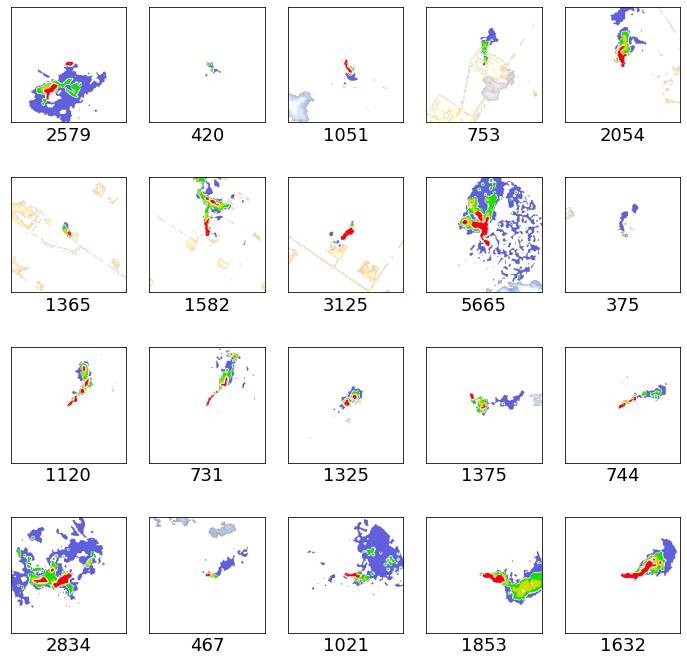

In [52]:
# Preview 20 images 
print('Image Preview and Plume Rate')
plt.figure(figsize=(12,12))

for i in range(20):  
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_set[i])
    plt.xlabel(str(int(Y[i])), fontsize = 18 )

plt.show()

### Build the CNN to Regression Model: 4 Conv2 layers with 32 filters, a Flatenning layer, and for Dense layers with a  25% Dropout layer.  Note the input shape of (160, 160, 4) which carries the opacity or alpha layer forward into the model. This is needed to 'washout' the background.

In [53]:
# Build CNN Regression Model - Had difficulty loading Flip and Rotation. It was used in other models later

regressor = Sequential()
#regressor.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
#regressor.add(layers.experimental.preprocessing.RandomRotation(0.2))
regressor.add(Conv2D(32, (3, 3), input_shape = (160, 160, 4), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Conv2D(32, (3, 3), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Conv2D(32, (3, 3), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Conv2D(32, (3, 3), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Flatten())
regressor.add(Dense(units = 128, activation = 'relu'))
regressor.add(Dropout(0.25))
regressor.add(Dense(units = 128, activation = 'linear'))
regressor.add(Dense(units = 3, activation = 'linear'))
regressor.add(Dense(units = 1, activation = 'linear'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [54]:
#Compile
regressor.compile(optimizer = 'adam', loss = 'MSE', metrics = ['mean_absolute_percentage_error'])

In [55]:
# Add liveloss plot as a callbacks to monitor progress when fitting below
import livelossplot
from keras.callbacks import EarlyStopping, ModelCheckpoint
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=5, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath = 'Reduced_PlumeOnly_CNN_Rev14_preScld_MinMax_4CV2_4D_DO_25_adam_weights.h5',
                                  save_weights_only=True, monitor = 'loss', mode = 'min', save_best_only=True)

#### Check the scaled min & max target values and the characteristic of the samples in this space.

In [56]:
min(y), max(y)

(array([0.]), array([1.]))

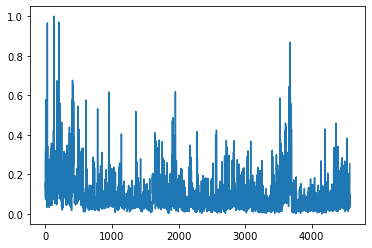

In [57]:
plt.plot(y)
plt.show()

#### Train - Test split with the q-plume bins to be able to stratify proportionately on the plume rate bins.

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# Build train and test set from the undersampled image dataset (test and validation at 469 leaves 1024 for training)
x_train, x_test, y_train, y_test, bin_train, bin_test = train_test_split(image_set, y, q_bin, stratify = q_bin, test_size = 0.25, random_state = 8)

#### Train the model - validate on 33% of the train set which is equivalent to 25% of the entire set and the same size as the test set.

#### The model was restarted a few times. The best result was after early stopping at epoch 37.

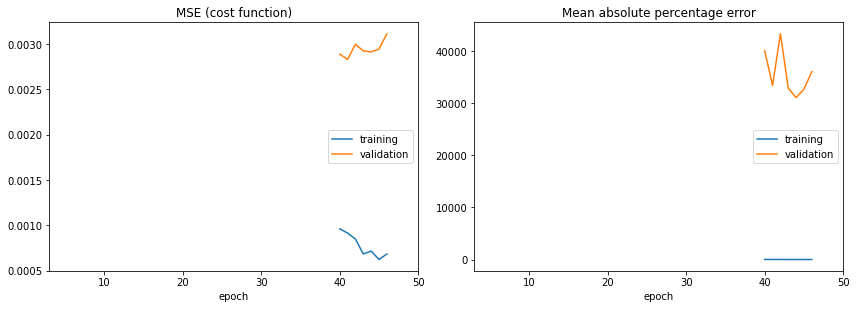

MSE (cost function):
training   (min:    0.001, max:    0.001, cur:    0.001)
validation (min:    0.003, max:    0.003, cur:    0.003)

Mean absolute percentage error:
training   (min:   37.302, max:   49.291, cur:   37.949)
validation (min: 31038.356, max: 45447.234, cur: 36048.831)


In [170]:
# Fit the model & train for 10 epochs initially, livelossplot in callbacks, validation split 
# and higher batch size to improve speed
regressor.fit(x_train, y_train, validation_split = 0.33, 
          callbacks = [live_plot, early_stop, model_checkpoint], initial_epoch = 37, epochs = 50, batch_size = 128)

In [171]:
regressor.save('Reduced_PlumeOnly_CNN_Rev14_preScld_MinMax_4CV2_4D_DO_25_adam_Ep46.h5')

### This later run had a negative minimum in the prediction where the results were then shifted. The Epoch 37 results did not have a negative minimum.  Using absolute value is a better solution than the shift.

In [197]:
ypred = (regressor.predict(x_test))
min(ypred), max(ypred)

(array([-0.01728413], dtype=float32), array([0.5505616], dtype=float32))

In [198]:
ypred = ypred + 0.01728413 + 0.00001

In [199]:
ypred[0:5]

array([[0.32641867],
       [0.04806615],
       [0.05778375],
       [0.08642862],
       [0.20423739]], dtype=float32)

In [200]:
y_test[0:5]

array([[0.414501  ],
       [0.01207723],
       [0.00913398],
       [0.05588833],
       [0.16090237]])

#### Rescale the results with the inverse scaler and then the numpy power function to reverse the (3/4) power prescaling. 

In [201]:
ypred_scld = np.power(scaler.inverse_transform(ypred), (4/3) )
ytest_scld = np.power(scaler.inverse_transform(y_test), (4/3) )
ypred_scld[0:5]

array([[2667.9172 ],
       [ 235.3974 ],
       [ 293.76834],
       [ 482.6641 ],
       [1447.3336 ]], dtype=float32)

In [202]:
min(ypred_scld), max(ypred_scld)

(array([11.841036], dtype=float32), array([5527.747], dtype=float32))

In [203]:
ytest_scld[0:5]

array([[3650.81914  ],
       [  53.8223096],
       [  42.2824182],
       [ 282.132462 ],
       [1063.38635  ]])

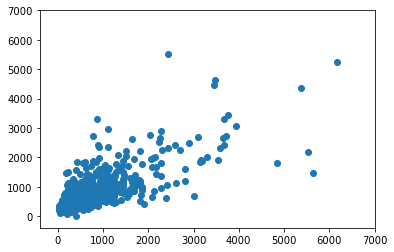

In [204]:
plt.scatter( x = ytest_scld, y = ypred_scld)
#plt.scatter( x = [0,4000], y = [0,4000], linestyle_str = '-')
plt.xlim(-400, 7000)
plt.ylim(-400, 7000)
plt.show()

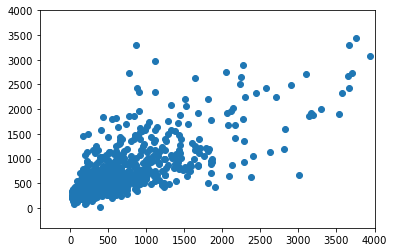

In [205]:
# Zoom in to the maximum 4000 range
plt.scatter( x = ytest_scld, y = ypred_scld)
#plt.scatter( x = [0,4000], y = [0,4000], linestyle_str = '-')
plt.xlim(-400, 4000)
plt.ylim(-400, 4000)
plt.show()

In [206]:
ytrain = (regressor.predict(x_train))
min(ytrain), max(ytrain)

(array([-0.00298751], dtype=float32), array([0.99620014], dtype=float32))

In [207]:
ytrain = ytrain + 0.00298751 + 0.00001

In [208]:
ytrain[0:5]

array([[0.05594487],
       [0.06821203],
       [0.02600161],
       [0.09555226],
       [0.07840127]], dtype=float32)

In [209]:
predtrain_scld = np.power(scaler.inverse_transform(ytrain), (4/3) )
y_train_scld = np.power(scaler.inverse_transform(y_train), (4/3) )
predtrain_scld[0:5]

array([[282.47784],
       [359.81055],
       [116.38723],
       [547.4251 ],
       [427.42136]], dtype=float32)

In [210]:
y_train_scld[0:5]

array([[454.498367 ],
       [487.3075143],
       [ 92.5177198],
       [532.7532851],
       [243.2100012]])

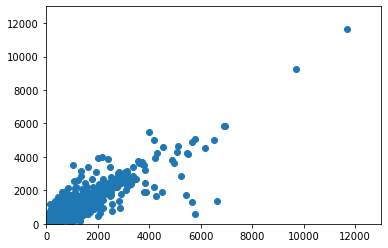

In [211]:
plt.scatter( x = y_train_scld, y = predtrain_scld)
plt.xlim(0, 13000)
plt.ylim(0, 13000)
plt.show()

### Plot the test results on top of the results putting the train set through the model.

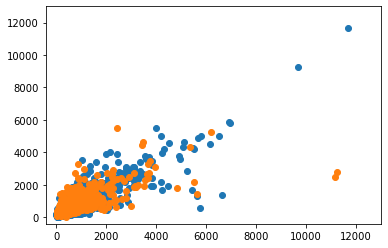

In [212]:
plt.scatter( x = y_train_scld, y = predtrain_scld)
plt.scatter( x = ytest_scld, y = ypred_scld)
plt.xlim(-400, 13000)
plt.ylim(-400, 13000)
plt.show()

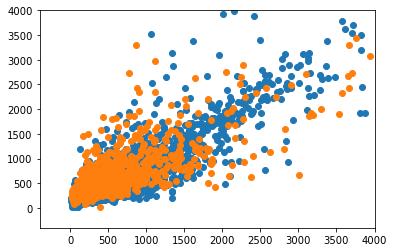

In [213]:
plt.scatter( x = y_train_scld, y = predtrain_scld)
plt.scatter( x = ytest_scld, y = ypred_scld)
plt.xlim(-400, 4000)
plt.ylim(-400, 4000)
plt.show()

### Check the RMSE performance on the first 20 images in the test set. Then below show the acual vs predicted plume rates on 20 images from 80 to 100 in the test set.

In [78]:
import random
from sklearn.metrics import mean_squared_error as mse

In [214]:
val = mse(ytest_scld[0:20], ypred_scld[0:20], squared = False)
print("First 20 predicstions have RMSE of ", int(val))

First 20 predicstions have RMSE of  403


Image Preview of First 20 Test Set Images with Plume Rate & Predicted Plume Rate


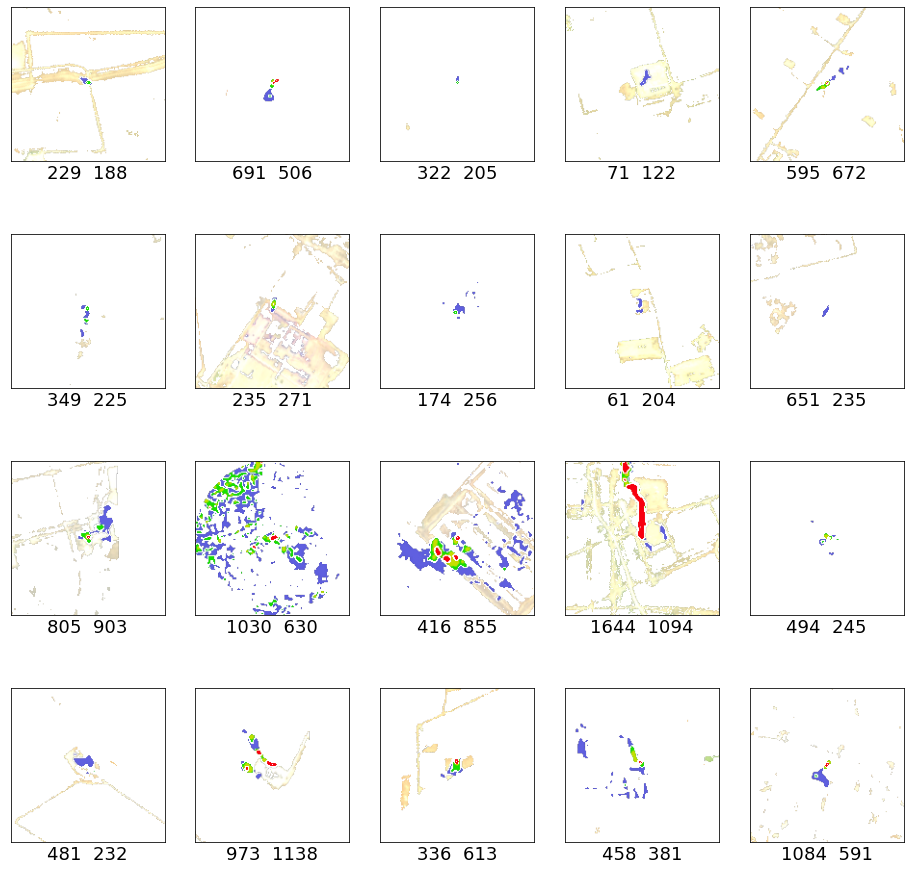

In [215]:
# Preview 20 images
offset = 80
a = offset
b = offset + 20
print('Image Preview of First 20 Test Set Images with Plume Rate & Predicted Plume Rate')
plt.figure(figsize=(16,16))
pred20 = abs(regressor.predict(x_test[a:b]))
pred20_scld = np.power(scaler.inverse_transform(pred20), (4/3) )
Y_test = np.power(scaler.inverse_transform(y_test[a:b]), (4/3) )
for i in range(20):  
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[a+i])
    plt.xlabel(str(int(Y_test[i])) + '  ' + str(int(pred20_scld[i])), fontsize = 18 ) 

plt.show()

### Calculate the RMSE on 100 ramdome samples of 20 images in the test set and plot the distribution.

In [219]:
# Calculate RMSE of 20 randomly selected groups of 20 images 
L = len(ypred_scld)
Sample_Range_RMSE = []
Sample_Image_Index = []
for j in range(100):
    rs = random.randint(0, L - 20) 
    val = mse(ytest_scld[rs:rs+20], ypred_scld[rs:rs+20], squared = False)
    Sample_Image_Index.append(rs)
    Sample_Range_RMSE.append(int(val))
print(Sample_Image_Index, '\n', Sample_Range_RMSE)
print(min(Sample_Range_RMSE), max(Sample_Range_RMSE))

[286, 924, 222, 269, 224, 272, 1111, 386, 132, 525, 37, 1115, 426, 855, 338, 26, 552, 846, 489, 484, 65, 924, 873, 695, 603, 97, 152, 34, 668, 83, 231, 460, 469, 609, 904, 21, 132, 473, 118, 622, 220, 246, 1022, 665, 840, 819, 290, 246, 462, 937, 1003, 453, 436, 393, 978, 206, 1031, 350, 329, 890, 588, 806, 396, 1084, 948, 438, 816, 281, 223, 1112, 868, 646, 204, 782, 157, 679, 698, 324, 175, 477, 301, 524, 819, 1043, 234, 254, 517, 806, 943, 575, 562, 830, 297, 516, 1098, 28, 615, 882, 345, 552] 
 [335, 389, 288, 457, 364, 429, 210, 554, 347, 448, 847, 240, 341, 568, 387, 478, 199, 644, 513, 459, 293, 389, 435, 188, 339, 545, 376, 860, 283, 262, 368, 475, 271, 314, 420, 412, 347, 226, 969, 179, 299, 289, 391, 332, 964, 294, 315, 289, 488, 339, 244, 514, 382, 524, 345, 254, 271, 404, 367, 488, 304, 315, 511, 574, 293, 373, 283, 446, 363, 211, 398, 370, 310, 421, 298, 352, 233, 533, 349, 248, 264, 473, 294, 441, 342, 323, 355, 315, 322, 2014, 2014, 811, 337, 339, 761, 476, 301, 368, 313

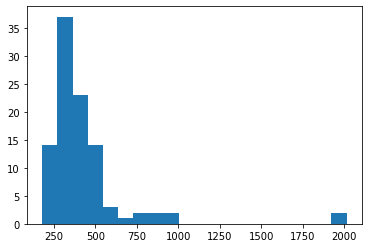

In [221]:
plt.hist(Sample_Range_RMSE, bins = 20)
plt.show()

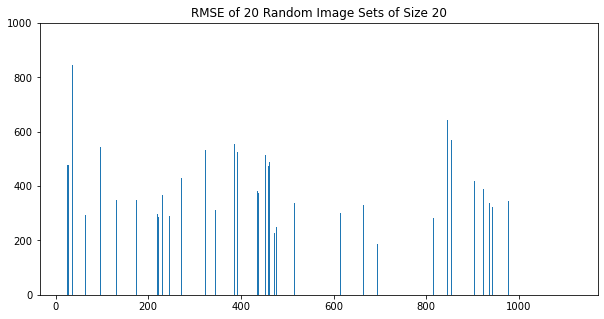

In [222]:
plt.figure(figsize=(10,5))
plt.title('RMSE of 20 Random Image Sets of Size 20')
plt.bar(x = Sample_Image_Index, height = Sample_Range_RMSE ) 
plt.ylim(0,1000)
plt.show()

### Overlay the Plume variance ( Q +/- Sigma ) with the model test and train performance at different scales.

Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands For Permian (left) and Plume Att (right) Sets


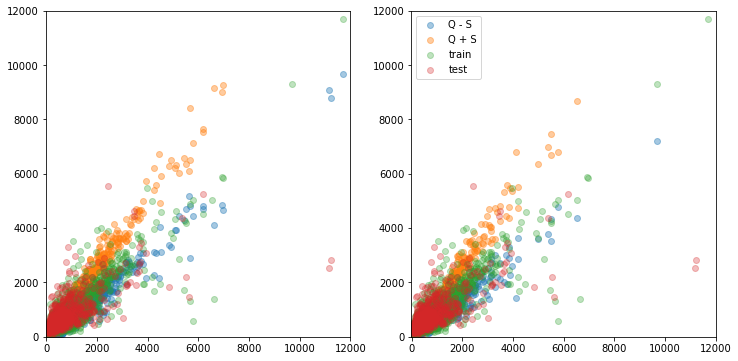

In [223]:
print('Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands For Permian (left) and Plume Att (right) Sets')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter( x = perm_list['qplume'], y = perm_list['qplume'] - perm_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = perm_list['qplume'], y = perm_list['qplume'] + perm_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 12000)
plt.ylim(-10, 12000)
plt.subplot(1,2,2)
plt.scatter( x = plume_att['qplume'], y = plume_att['qplume'] - plume_att['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = plume_att['qplume'], y = plume_att['qplume'] + plume_att['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 12000)
plt.ylim(-10, 12000)
plt.legend()
plt.show()

Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands For Permian (left) and Plume Att (right) Sets


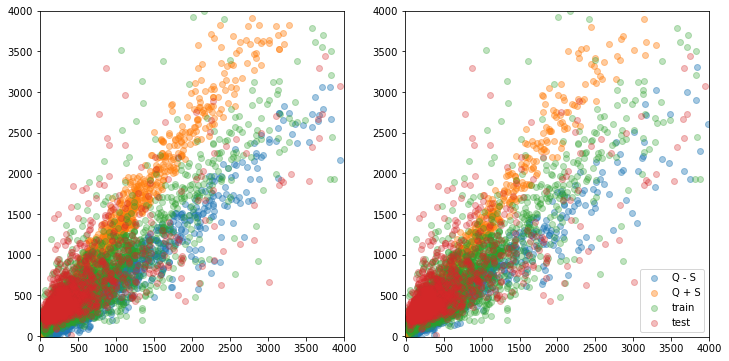

In [224]:
print('Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands For Permian (left) and Plume Att (right) Sets')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter( x = perm_list['qplume'], y = perm_list['qplume'] - perm_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = perm_list['qplume'], y = perm_list['qplume'] + perm_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 4000)
plt.ylim(-10, 4000)
plt.subplot(1,2,2)
plt.scatter( x = plume_att['qplume'], y = plume_att['qplume'] - plume_att['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = plume_att['qplume'], y = plume_att['qplume'] + plume_att['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 4000)
plt.ylim(-10, 4000)
plt.legend()
plt.show()

In [225]:
Qs = perm_list['qplume']
Qs = Qs.append(plume_att['qplume'])

Qplus =  perm_list['qplume'] + perm_list['sigma_qplume']
Qplus = Qplus.append(plume_att['qplume'] + plume_att['sigma_qplume'])

Qminus =  perm_list['qplume'] - perm_list['sigma_qplume']
Qminus = Qminus.append(plume_att['qplume'] - plume_att['sigma_qplume'])

Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands For Permian (left) and Plume Att (right) Sets /n


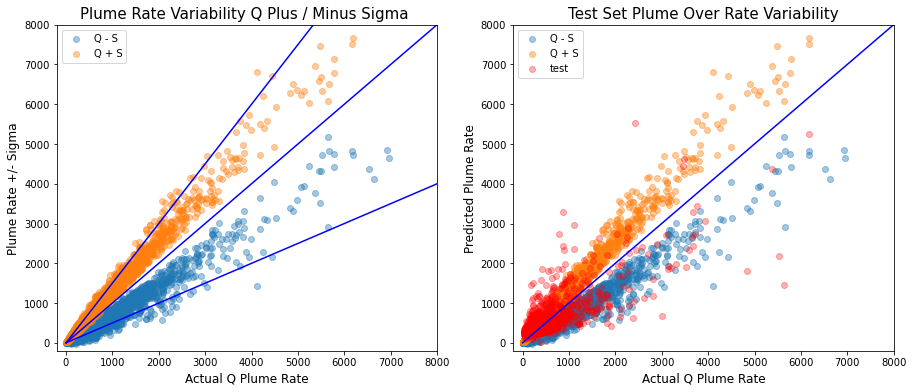

In [226]:
print('Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands For Permian (left) and Plume Att (right) Sets /n')
lim1 = 8000
lim2 = 8000
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Plume Rate Variability Q Plus / Minus Sigma ', fontsize =15)
plt.scatter( x = Qs, y = Qminus , marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = Qs, y = Qplus, marker = 'o', alpha = 0.4, label = 'Q + S')
plt.plot ([0, lim1], [0, lim1/2], 'k-', c = 'b')
plt.plot ([0, lim1], [0, lim1*3/2], 'k-', c = 'b')
plt.plot ([0, lim1], [0, lim1], 'k-', c = 'b')
plt.xlabel('Actual Q Plume Rate', fontsize = 12)
plt.ylabel('Plume Rate +/- Sigma', fontsize = 12)
#plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
#plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.legend()
plt.xlim(-200, lim1)
plt.ylim(-200, lim1)
plt.subplot(1,2,2)
plt.title('Test Set Plume Over Rate Variability', fontsize =15)
plt.scatter( x = Qs, y = Qminus , marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = Qs, y = Qplus, marker = 'o', alpha = 0.4, label = 'Q + S')
#plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, c = 'red', label = 'test')
plt.plot ([0, lim1], [0, lim1], 'k-', c = 'b')
plt.xlabel('Actual Q Plume Rate', fontsize = 12)
plt.ylabel('Predicted Plume Rate', fontsize = 12)
plt.xlim(-200, lim2)
plt.ylim(-200, lim2)
plt.legend()
plt.show()